In [1]:
import pandas as pd
import os 
import scanpath as scp
import math
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def get_file_data(file):
    file_path = os.path.join('./data/scanpaths/', file)
    df = pd.read_csv(file_path, delimiter='\t')
    cols = df.columns.to_list()
    df['file'] = file.replace("_scanpath.tsv", "")
    df = df[['file'] + cols]
    return df

In [3]:
files = [i for i in os.listdir('./data/scanpaths/')]
master_df = get_file_data(files[0])

for i  in  files[1:]:
    master_df = pd.concat([master_df, get_file_data(i)])

In [4]:
all_columns = ['file', 'fixation_index', 'text_domain', 'trial', 'acc_bq_1', 'acc_bq_2', 'acc_bq_3', 'acc_tq_1', 'acc_tq_2', 'acc_tq_3',
'fixation_duration', 'next_saccade_duration', 'previous_saccade_duration', 'version', 'line', 'roi', 'char_index_in_line', 
'original_fixation_index', 'is_fixation_adjusted', 'reader_id', 'text_id', 'fixation_position_x', 'fixation_position_y',
'word_index_in_text', 'sent_index_in_text', 'char_index_in_text', 'word', 'character', 'text_id_numeric']

## Plot scanpaths


In [48]:
def plot_fixations(axs, scanpath, coordinate, color):
    # Sample data (time, x position, duration)
    time = scanpath['cum_fixation_duration'].to_list()
    if coordinate == "y":
        position = scanpath['fixation_position_y'].to_list()
    else:
        position = scanpath['fixation_position_x'].to_list()
    duration = scanpath['fixation_duration'].to_list()

    # Plot the horizontal lines
    list1 = []
    list2 = []
    for i in range(len(time)):
        list1.extend([position[i], position[i]])
        list2.extend([time[i], time[i] + duration[i]])
    axs.plot(list1, list2, color=color[0])

    for i in range(len(time)):
        axs.vlines(x=position[i], ymin=time[i], ymax=time[i] + duration[i], color=color[1])    

    # Add labels and title
    axs.set_ylabel('Time')
    if coordinate == "x":
        axs.set_xlabel('X Position')
    else:
        axs.set_xlabel('Y Position')
    return axs


def plot_scanpaths(axs, scanpathlist):
    color_comb = [('blue', 'red'), ('green', 'red'), ('purple', 'red') ]
    axs[0, 0] = plot_fixations(axs[0, 0], scanpathlist[0], "x", color_comb[0])
    axs[0, 1] = plot_fixations(axs[0, 1], scanpathlist[1], "x", color_comb[1])
    axs[1, 0] = plot_fixations(axs[1, 0], scanpathlist[0], "y", color_comb[0])
    axs[1, 1] = plot_fixations(axs[1, 1], scanpathlist[1], "y", color_comb[1])
    return axs



def plot_alignments_component(axs, scanpath, scanno, coordinate, color):

    # time = scanpath['cum_fixation_duration' + "_" + scanno].to_list()
    # duration = scanpath['fixation_duration'+ "_" + scanno].to_list()

    time = list(range(scanpath.shape[0]))
    duration = np.ones(shape= alignment.shape[0]).tolist()
    if coordinate == "y":
        position = scanpath['fixation_position_y'+ "_" + scanno].to_list()
    else:
        position = scanpath['fixation_position_x'+ "_" + scanno].to_list()

    # Plot the horizontal lines
    list1 = []
    list2 = []
    for i in range(len(time)):
        list1.extend([position[i], position[i]])
        list2.extend([time[i], time[i] + duration[i]])
    axs.plot(list1, list2, color=color[0])

    for i in range(len(time)):
        axs.vlines(x=position[i], ymin=time[i], ymax=time[i] + duration[i], color=color[1])    

    # Add labels and title
    axs.set_ylabel('Steps')
    if coordinate == "x":
        axs.set_xlabel('X Position')
    else:
        axs.set_xlabel('Y Position') 

    return axs

def plot_alignments(axs, alignment):
    color_comb = [('blue', 'red'), ('green', 'red'), ('purple', 'red') ]
    axs[0, 2] = plot_alignments_component(axs[0, 2], alignment, "s", 'x', color_comb[0])
    axs[0, 3] = plot_alignments_component(axs[0, 3], alignment, "t", 'x', color_comb[1])
    axs[0, 4] = plot_alignments_component(axs[0, 4], alignment, "s", 'x', color_comb[0])
    axs[0, 4] = plot_alignments_component(axs[0, 4], alignment, "t", 'x', color_comb[1])

    axs[1, 2] = plot_alignments_component(axs[1, 2], alignment, "s", 'y', color_comb[0])
    axs[1, 3] = plot_alignments_component(axs[1, 3], alignment, "t", 'y', color_comb[1])
    axs[1, 4] = plot_alignments_component(axs[1, 4], alignment, "s", 'y', color_comb[0])
    axs[1, 4] = plot_alignments_component(axs[1, 4], alignment, "t", 'y', color_comb[1])
    return axs


## Process scanpaths

In [60]:
def get_scanpath(scan_record):
    scanpath = master_df[master_df['file'] == scan_record]
    scanpath = scanpath[['fixation_index', 'fixation_duration', 'next_saccade_duration', 'previous_saccade_duration', 'line', 'char_index_in_line',
                    'fixation_position_x', 'fixation_position_y', 'word_index_in_text', 'sent_index_in_text', 'char_index_in_text']]
    scanpath['change_in_word_flag'] = (scanpath['word_index_in_text'].diff() == 0).astype(int).shift(-1)
    scanpath['change_in_word'] = (scanpath['change_in_word_flag'] == 0).cumsum().shift(1).fillna(0)
    scanpath['same_word_next_saccade_duration'] = scanpath['change_in_word_flag']*scanpath['next_saccade_duration']
    scanpath['next_saccade_duration'] = scanpath['next_saccade_duration'] - scanpath['same_word_next_saccade_duration']
    scanpath['fixation_duration'] = scanpath['same_word_next_saccade_duration'] + scanpath['fixation_duration']
    scanpath = scanpath.drop('same_word_next_saccade_duration', axis =1)
    scanpath = scanpath.groupby(['change_in_word', 'word_index_in_text']).aggregate({'fixation_duration':'sum', 'next_saccade_duration':'sum', 'fixation_position_x':'mean', 'fixation_position_y':'mean'}).reset_index()
    scanpath['cum_fixation_duration'] = scanpath['fixation_duration'].cumsum().shift(1).fillna(0)
    scanpath = scanpath.reset_index()
    return scanpath

/Users/RSingh81/anaconda3/envs/py38/lib/python3.8/site-packages/matplotlib/axes/_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


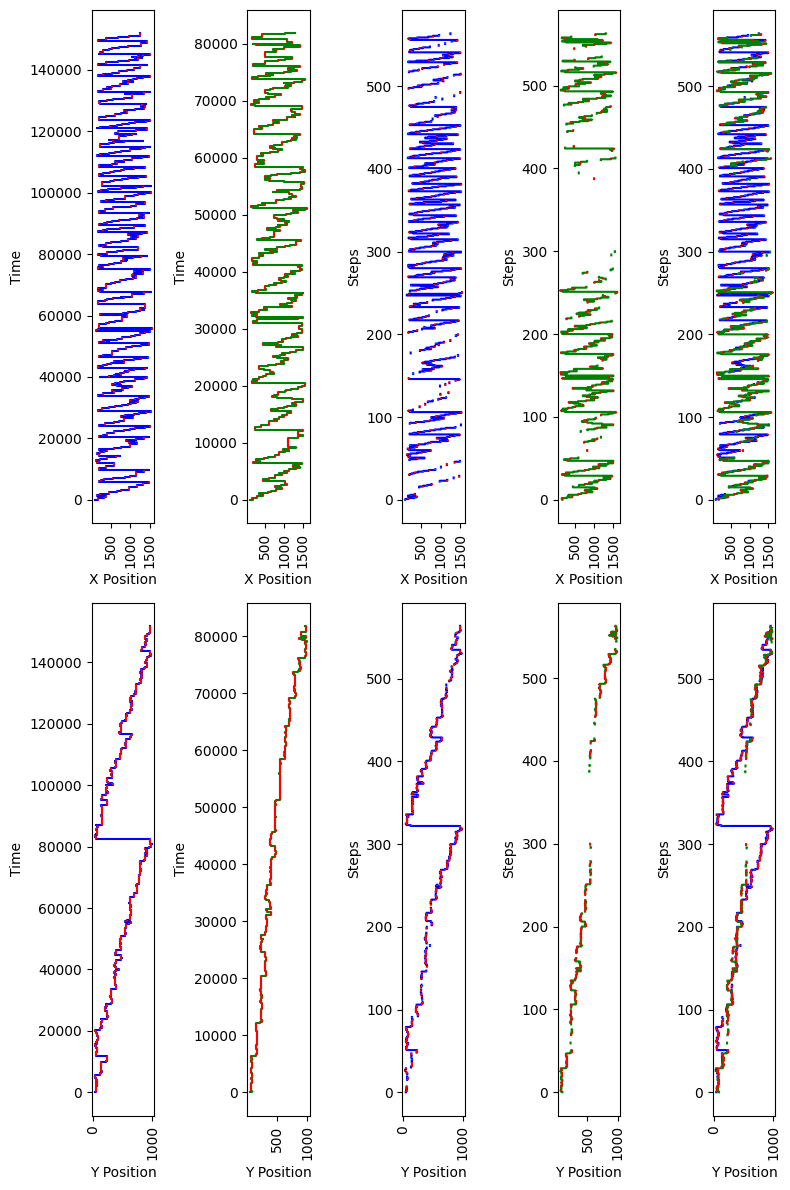

In [64]:
center_x = 840
center_y = 525
distance = 61
unit = 0.0282
scanpath1 = get_scanpath('reader70_p5')
scanpath2 = get_scanpath('reader71_p5')

score, path, alignment  = scp.rscasim(scanpath1, scanpath2, center_x, center_y, distance, unit, modulator=0.83)
alignment = alignment.drop(0, axis=0).reset_index(drop=True)
alignment = alignment.merge(scanpath1[['index', 'fixation_position_x', 'fixation_position_y', 'fixation_duration', 'cum_fixation_duration']], left_on='s', right_on='index', how='left').rename(columns={'fixation_position_x':'fixation_position_x_s', 'fixation_position_y':'fixation_position_y_s',                                                                                                                                                                                         'fixation_duration':'fixation_duration_s', 'cum_fixation_duration':'cum_fixation_duration_s'}).drop('index', axis=1)
alignment = alignment.merge(scanpath2[['index', 'fixation_position_x', 'fixation_position_y', 'fixation_duration', 'cum_fixation_duration']], left_on='t', right_on='index', how='left').rename(columns={'fixation_position_x':'fixation_position_x_t', 'fixation_position_y':'fixation_position_y_t',
                                                                                                                                                                                                         'fixation_duration':'fixation_duration_t', 'cum_fixation_duration':'cum_fixation_duration_t'}).drop('index', axis=1)

fig, axs = plt.subplots(2, 5, figsize=(8, 12))
axs = plot_scanpaths(axs, [scanpath1, scanpath2])
axs = plot_alignments(axs, alignment)

for ax in axs:
    for axx in ax:
        axx.tick_params(axis='x', rotation=90)

plt.tight_layout()
fig.tight_layout()